In [115]:
# data from https://www.kaggle.com/datasets/rmisra/news-category-dataset
import json

data = []
for line in open('data/News_Category_Dataset_v3.json'):
    data.append(json.loads(line))

# to pandas dataframe
import pandas as pd
df = pd.json_normalize(data)

# randomly sample 1000 rows
df = df.sample(n=1000)


df.head()

,link,headline,category,short_description,authors,date
166048,https://www.huffingtonpost.com/entry/embarrass...,Embarrassing Cocktail Names: We Dare You Not T...,FOOD & DRINK,"We're all adults here, but there are things ev...",,2013-05-08
68680,https://www.huffingtonpost.comhttp://pubx.co/g...,Opossum Was Too Scared To Even Move — But Some...,GOOD NEWS,Even the simplest of act can make a world of d...,,2016-04-30
104605,https://www.huffingtonpost.com/entry/20-ways-t...,20 Ways To Find Your Life Purpose,HEALTHY LIVING,You're ready to find out what you are here for...,"Deborah Chalk, ContributorMartha Beck Certifie...",2015-03-18
63958,https://www.huffingtonpost.com/entry/house-app...,"GOP-Led House Ignores Dems' Sit-In, Approves $...",POLITICS,The move short-changes President Barack Obama'...,"Susan Cornwell, Reuters",2016-06-23
141008,https://www.huffingtonpost.com/entry/st-moritz...,"In St. Mortiz, a Five-star Resort Sets the Sta...",TRAVEL,My recent trip this month found St. Moritz in ...,"John Mariani, Contributor\nPublisher of Marian...",2014-01-28


In [116]:
# make headline and short description into one column
df['text'] = df['headline'] + ' ' + df['short_description']

list_of_text = df['text'].to_list()

# NLP: text pre-processing with nltk


In [117]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from gensim import corpora

en_stop = set(stopwords.words('english'))

def get_lemma2(word):
    from nltk.stem.wordnet import WordNetLemmatizer
    """
    This function takes a word and returns its rootword
    """
    return WordNetLemmatizer().lemmatize(word)
# remove extra characters
import re
def clean_chr(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text

def nltk_preprocessing(text):
    """
    This function takes a text and returns a list of tokens
    - lowercase
    - remove short words
    - remove stopwords
    - remove extra characters
    - gets root word (lemma)

    """
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if len(token) > 4]      # remove short words
    tokens = [token for token in tokens if token not in en_stop] # remove stopwords
    tokens = [clean_chr(token) for token in tokens]              # remove extra characters
    tokens = [get_lemma2(token) for token in tokens]
    return tokens

In [118]:
# clean data
clean_train_text = [nltk_preprocessing(text) for text in list_of_text]


# Word2Vec with gensim

In [119]:
from gensim.models import word2vec

n_space = 1000
# train word2vec model
model_w2v = word2vec.Word2Vec(clean_train_text, size=n_space, window=5, min_count=1, workers=4)
model_w2v.build_vocab(clean_train_text, update=True)

# train using w2v
model_w2v.train(clean_train_text, total_examples=len(clean_train_text), epochs=1)

# save model
model_w2v.save('models/model_w2v')

In [120]:
import numpy as np

def buildWordVector(text, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in text:
        try:
            vec += model_w2v[word].reshape((1, size))
            count += 1.
        except KeyError:
            continue
    if count != 0:
        vec /= count
    return vec

# scale the data for training
from sklearn.preprocessing import scale
word_vecs = np.concatenate([buildWordVector(z, n_space) for z in clean_train_text])

/tmp/ipykernel_394478/2497630709.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vec += model_w2v[word].reshape((1, size))


now we have a vector representation of each word in our list `word_vecs` which looks like: 
```
array([[ 0.68491604,  2.01373113,  2.59129064, ...,  0.37546405,
        -1.49053731, -0.43113023],
       [ 0.42085448,  0.26101776,  0.38303052, ..., -0.08395418,
        -0.68023642,  0.69063785],...
```

one row for each of the 1000 articles and each column is a dimension of the vector (we arbitrarily chose 100 dimensions).

# Plot this (1000,100) matrix as a 2D scatter plot

To do this we have to reduce the number of columns from 100 to 2... to do this we use a dimentionality reduction model. One model is PCA.


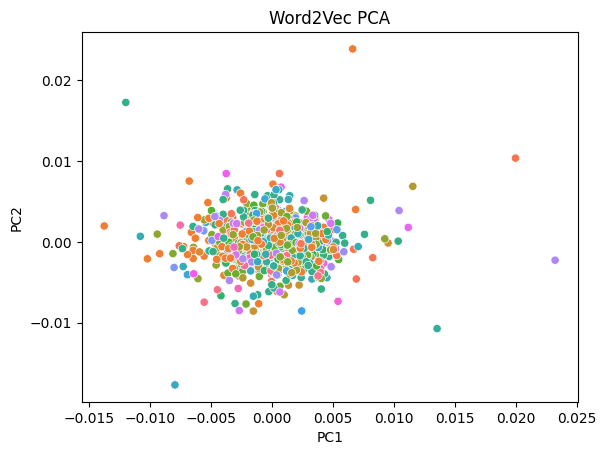

In [121]:
from sklearn.decomposition import PCA

# reduce to 2 dimensions
pca = PCA(n_components=2)
pca.fit(word_vecs)
pca_coord = pca.transform(word_vecs)

# plot
import seaborn as sns
sns.scatterplot(x=pca_coord[:,0], y=pca_coord[:,1], hue=df['category'])

# hide the legend
plt.legend().set_visible(False)

import matplotlib.pyplot as plt
plt.xlabel('PC1')
plt.ylabel('PC2')

# remember the x and y don't really mean anything... just the relative distance between points
plt.title('Word2Vec PCA')
plt.show()

For this plot, each dot represents one article, colored by the category (given in the dataset). There are a few points that are way out in space.. those might be interesting to explore. But we don't see any clear clusters of articles... maybe we need to do some more work on the text pre-processing.

/home/madis/sandbox/nlp-sandbox/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


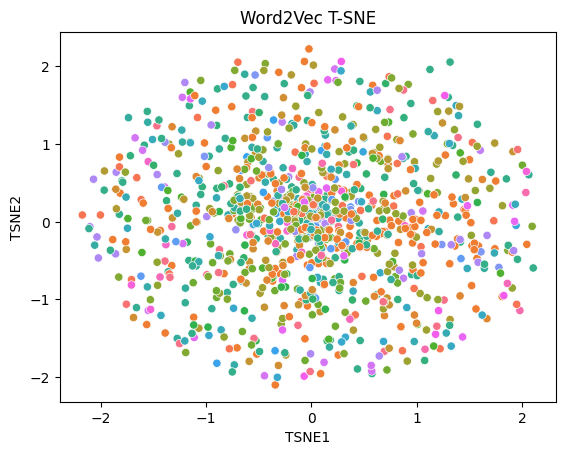

In [122]:
# tsne is another dimensionality reduction technique. It is more computationally expensive than PCA
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=275, n_iter=1000,  random_state=0, init='pca', learning_rate='auto')
np.set_printoptions(suppress=True)
Y = tsne.fit_transform(word_vecs)

# plot tsne
import seaborn as sns
sns.scatterplot(x=Y[:, 0], y=Y[:, 1], hue=df['category'])
# hide the legend
plt.legend().set_visible(False)

import matplotlib.pyplot as plt
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')

# remember the x and y don't really mean anything... just the relative distance between points
plt.title('Word2Vec T-SNE')
plt.show()


In [123]:
# append Y to df
df['x'] = Y[:,0]
df['y'] = Y[:,1]

# save df
df.to_csv('data/news.csv', index=False)

df.head()

,link,headline,category,short_description,authors,date,text,x,y
166048,https://www.huffingtonpost.com/entry/embarrass...,Embarrassing Cocktail Names: We Dare You Not T...,FOOD & DRINK,"We're all adults here, but there are things ev...",,2013-05-08,Embarrassing Cocktail Names: We Dare You Not T...,-0.873015,-0.359508
68680,https://www.huffingtonpost.comhttp://pubx.co/g...,Opossum Was Too Scared To Even Move — But Some...,GOOD NEWS,Even the simplest of act can make a world of d...,,2016-04-30,Opossum Was Too Scared To Even Move — But Some...,-0.559788,1.419350
104605,https://www.huffingtonpost.com/entry/20-ways-t...,20 Ways To Find Your Life Purpose,HEALTHY LIVING,You're ready to find out what you are here for...,"Deborah Chalk, ContributorMartha Beck Certifie...",2015-03-18,20 Ways To Find Your Life Purpose You're ready...,-1.616248,0.285419
63958,https://www.huffingtonpost.com/entry/house-app...,"GOP-Led House Ignores Dems' Sit-In, Approves $...",POLITICS,The move short-changes President Barack Obama'...,"Susan Cornwell, Reuters",2016-06-23,"GOP-Led House Ignores Dems' Sit-In, Approves $...",-1.325771,-0.563553
141008,https://www.huffingtonpost.com/entry/st-moritz...,"In St. Mortiz, a Five-star Resort Sets the Sta...",TRAVEL,My recent trip this month found St. Moritz in ...,"John Mariani, Contributor\nPublisher of Marian...",2014-01-28,"In St. Mortiz, a Five-star Resort Sets the Sta...",-0.187022,0.364987
